In [ ]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

filePath = "/content/drive/My Drive/Udacity-MLE-Capstone-Starbucks-data/"

# read in the json files
#portfolio = pd.read_json(filePath+'data/portfolio.json', orient='records', lines=True)
#profile = pd.read_json(filePath+'data/profile.json', orient='records', lines=True)
#transcript = pd.read_json(filePath+'data/transcript.json', orient='records', lines=True)

predictOfferViewed = 0

if predictOfferViewed:
  # Load data for training
  X = pd.read_pickle(filePath+'dataViewedX.pkl')
  Y = pd.read_pickle(filePath+'dataViewedY.pkl')
else:
  # Load data for training
  X = pd.read_pickle(filePath+'dataX.pkl')
  Y = pd.read_pickle(filePath+'dataY.pkl')

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# setting up torch device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('GPU is available.' if torch.cuda.is_available() else 'GPU is NOT avaliable, using CPU.')

GPU is available.


# Prepare and Split Data

In [ ]:
Y

0        0
1        1
2        0
3        1
4        1
        ..
66496    0
66497    0
66498    0
66499    1
66500    1
Name: offer_completed, Length: 66501, dtype: int64

In [ ]:
X

,difficulty,duration,reward,chan_social,chan_email,chan_web,chan_mobile,offer_type_bogo,offer_type_discount,offer_type_informational,age,income,joinDate_month,joinDate_year,gender_F,gender_M,gender_O
0,0.5,0.571429,1.0,1,1,0,1,1,0,0,0.554217,0.777778,0.727273,0.8,0,1,0
1,0.5,0.571429,1.0,1,1,0,1,1,0,0,0.554217,0.777778,0.727273,0.8,0,1,0
2,0.0,0.142857,0.0,0,1,1,1,0,0,1,0.554217,0.777778,0.727273,0.8,0,1,0
3,1.0,1.000000,0.5,0,1,1,0,0,1,0,0.554217,0.777778,0.727273,0.8,0,1,0
4,1.0,1.000000,0.5,0,1,1,0,0,1,0,0.554217,0.777778,0.727273,0.8,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66496,0.5,0.571429,0.2,0,1,1,1,0,1,0,0.626506,0.544444,0.909091,0.6,1,0,0
66497,0.5,0.571429,0.2,0,1,1,1,0,1,0,0.626506,0.544444,0.909091,0.6,1,0,0
66498,0.5,0.571429,0.2,0,1,1,1,0,1,0,0.759036,0.711111,0.272727,1.0,1,0,0
66499,0.5,0.571429,0.2,0,1,1,1,0,1,0,0.156627,0.166667,0.545455,0.8,0,1,0


In [ ]:
# Print columns used as model features
print(X.columns)

Index(['difficulty', 'duration', 'reward', 'chan_social', 'chan_email',
       'chan_web', 'chan_mobile', 'offer_type_bogo', 'offer_type_discount',
       'offer_type_informational', 'age', 'income', 'joinDate_month',
       'joinDate_year', 'gender_F', 'gender_M', 'gender_O'],
      dtype='object')


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

# We split the dataset into 2/3 training and 1/3 testing sets.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

# Then we split the training set further into 2/3 training and 1/3 validation sets.
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, shuffle=True)

In [ ]:
print(X_train)
print(X_train.shape)

[[0.25       0.28571429 0.5        ... 0.         1.         0.        ]
 [0.5        0.57142857 0.2        ... 1.         0.         0.        ]
 [0.5        0.57142857 1.         ... 1.         0.         0.        ]
 ...
 [0.5        1.         0.2        ... 0.         1.         0.        ]
 [0.5        0.28571429 1.         ... 1.         0.         0.        ]
 [0.35       0.57142857 0.3        ... 1.         0.         0.        ]]
(42560, 17)


In [ ]:
print(Y_train)
print(Y_train.shape)

57458    1
21338    1
25575    0
4937     1
51035    0
        ..
1450     1
10124    0
16299    1
26090    1
17984    1
Name: offer_completed, Length: 42560, dtype: int64
(42560,)


In [ ]:
#test_tensor = torch.Tensor(X.values)

# Convert data into torch.Tensor:
X_train = torch.Tensor(X_train).to(device)
X_val = torch.Tensor(X_val).to(device)
X_test = torch.Tensor(X_test).to(device)

Y_train = torch.Tensor(Y_train.values).to(device)
Y_val = torch.Tensor(Y_val.values).to(device)
Y_test = torch.Tensor(Y_test.values).to(device)

# Create datasets for the dataloaders:
train_data = TensorDataset(X_train, Y_train)
test_data = TensorDataset(X_test, Y_test)
val_data = TensorDataset(X_val, Y_val)

# print out some data stats
print('# of training samples: ', len(train_data))
print('# of validation samples: ', len(val_data))
print('# of test samples: ', len(test_data))

batch_size = 64

# Creating the data loaders:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

loaders = {
    'train': train_loader,
    'valid': val_loader,
    'test': test_loader
}

# of training samples:  42560
# of validation samples:  10640
# of test samples:  13301


In [ ]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

torch.Size([42560, 17]) torch.Size([42560])
torch.Size([13301, 17]) torch.Size([13301])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

n_classes = 1 # Number of classes
n_features = 17 # Number of features

# define the DNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self, n_features):
        super(Net, self).__init__()
        ## Define layers of a DNN
        
        self.fc1 = nn.Linear(n_features, 32)
        # linear layer (17 -> 32)
        self.fc2 = nn.Linear(32, 32)
        # linear layer (32 -> 32)
        self.fc3 = nn.Linear(32, 32)
        # linear layer (32 -> 32)
        self.fc4 = nn.Linear(32, 32)
        # linear layer (32 -> 32)
        self.fc5 = nn.Linear(32, 32)
        # linear layer (32 -> 32)
        self.fc6 = nn.Linear(32, 32)
        # linear layer (32 -> 32)
        self.fc7 = nn.Linear(32, 32)
        # linear layer (32 -> 32)
        self.fc8 = nn.Linear(32, 32)
        # linear layer (32 -> 32)
        self.fc9 = nn.Linear(32, 32)
        # linear layer (32 -> 32)
        self.fc10 = nn.Linear(32, 32)
        # linear layer (32 -> 32)
        self.fc11 = nn.Linear(32, 32)
        # linear layer (32 -> 32)
        self.fc12 = nn.Linear(32, 32)
        # linear layer (32 -> 32)
        self.fc13 = nn.Linear(32, 32)
        # linear layer (32 -> 16)
        self.fc14 = nn.Linear(32, 16)
        # linear layer (16 -> 8)
        self.fc15 = nn.Linear(16, 8)
        # linear layer (8 -> 1)
        self.fc16 = nn.Linear(8, n_classes)
        
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        ## Define forward behavior
        
        # add 1st hidden layer, with relu activation function
        x = F.leaky_relu(self.fc1(x))

        #print("a3: ",x.shape)
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.leaky_relu(self.fc2(x))
        
        #print("a3: ",x.shape)
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.leaky_relu(self.fc3(x))

        #print("a3: ",x.shape)
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.leaky_relu(self.fc4(x))

        #print("a3: ",x.shape)
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.leaky_relu(self.fc5(x))

        #print("a3: ",x.shape)
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.leaky_relu(self.fc6(x))

        #print("a3: ",x.shape)
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.leaky_relu(self.fc7(x))

        #print("a3: ",x.shape)
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.leaky_relu(self.fc8(x))

        #print("a3: ",x.shape)
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.leaky_relu(self.fc9(x))

        #print("a3: ",x.shape)
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.leaky_relu(self.fc10(x))

        #print("a4: ",x.shape)
        # add dropout layer
        x = self.dropout(x)
        # add 3rd hidden layer
        x = F.leaky_relu(self.fc11(x))

        #print("a3: ",x.shape)
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.leaky_relu(self.fc12(x))

        #print("a3: ",x.shape)
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.leaky_relu(self.fc13(x))

        #print("a3: ",x.shape)
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.leaky_relu(self.fc14(x))

        #print("a4: ",x.shape)
        # add dropout layer
        x = self.dropout(x)
        # add 3rd hidden layer
        x = F.leaky_relu(self.fc15(x))

        #print("a4: ",x.shape)
        # add dropout layer
        #x = self.dropout(x)
        # add 3rd hidden layer
        x = self.fc16(x)

        #print("a5: ",x.shape)
        
        return x
    

# instantiate the CNN
model = Net(n_features)
print(model)

# move tensors to GPU if CUDA is available
if use_cuda:
    model.cuda()

Net(
  (fc1): Linear(in_features=17, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=32, bias=True)
  (fc7): Linear(in_features=32, out_features=32, bias=True)
  (fc8): Linear(in_features=32, out_features=32, bias=True)
  (fc9): Linear(in_features=32, out_features=32, bias=True)
  (fc10): Linear(in_features=32, out_features=32, bias=True)
  (fc11): Linear(in_features=32, out_features=32, bias=True)
  (fc12): Linear(in_features=32, out_features=32, bias=True)
  (fc13): Linear(in_features=32, out_features=32, bias=True)
  (fc14): Linear(in_features=32, out_features=16, bias=True)
  (fc15): Linear(in_features=16, out_features=8, bias=True)
  (fc16): Linear(in_features=8, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, in

In [ ]:
from torch import optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    print("Begin training...")
    
    train_losses, valid_losses = [], []
    for epoch in range(1, n_epochs+1):
        #print("Epoch: ",epoch)
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            #if batch_idx % 100 == 0:
                #print("Epoch: {}, Batch: {}".format(epoch,batch_idx))
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            output = output.view(-1)
            target = target.unsqueeze(0).view(-1)

            # calculate the batch loss
            loss = criterion(output, target)
            
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # perform a single optimization step (parameter update)
            optimizer.step()
            
            # record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        with torch.no_grad():
          model.eval()
          for batch_idx, (data, target) in enumerate(loaders['valid']):
              # move to GPU
              if use_cuda:
                  data, target = data.cuda(), target.cuda()
              ## update the average validation loss

              # forward pass: compute predicted outputs by passing inputs to the model
              output = model(data)
              #output = outputs.view(1, -1)  # make it the same shape as output
              target = target.unsqueeze(0).view(-1)
              output = output.view(-1)

              # calculate the batch loss
              loss = criterion(output, target)
              
              # update average validation loss 
              valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min, valid_loss))
                
            valid_loss_min = valid_loss
    
    print("Training Complete!")
    # return trained model
    return model, train_losses, valid_losses

In [ ]:
n_epochs = 300 # Number of training epochs

# train the model
model, train_losses, valid_losses = train(n_epochs, loaders, model, optimizer, 
                                          criterion, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model.load_state_dict(torch.load('model_scratch.pt'))

Begin training...
Epoch: 1 	Training Loss: 0.573564 	Validation Loss: 0.537920
Validation loss decreased (inf --> 0.537920).  Saving model ...
Epoch: 2 	Training Loss: 0.535183 	Validation Loss: 0.529537
Validation loss decreased (0.537920 --> 0.529537).  Saving model ...
Epoch: 3 	Training Loss: 0.514543 	Validation Loss: 0.500754
Validation loss decreased (0.529537 --> 0.500754).  Saving model ...
Epoch: 4 	Training Loss: 0.500594 	Validation Loss: 0.489475
Validation loss decreased (0.500754 --> 0.489475).  Saving model ...
Epoch: 5 	Training Loss: 0.490948 	Validation Loss: 0.482810
Validation loss decreased (0.489475 --> 0.482810).  Saving model ...
Epoch: 6 	Training Loss: 0.487868 	Validation Loss: 0.477274
Validation loss decreased (0.482810 --> 0.477274).  Saving model ...
Epoch: 7 	Training Loss: 0.481773 	Validation Loss: 0.470996
Validation loss decreased (0.477274 --> 0.470996).  Saving model ...
Epoch: 8 	Training Loss: 0.480271 	Validation Loss: 0.463141
Validation loss 

<All keys matched successfully>

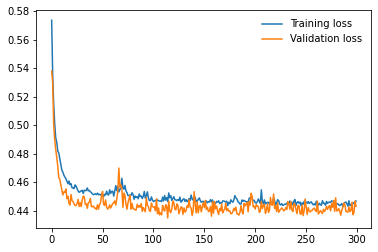

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def calcROC(model, X, y):
  ''' Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores. '''

  print('ROC AUC Score:',roc_auc_score(y, model.predict_proba(X)[:, 1]))

  plot_roc_curve(model, X, y)  
  plt.show()

In [ ]:
def test(loaders, model, criterion, use_cuda):
    
    print("Begin Test!")
    
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    
    y_pred_list = []
    target_list = []
    y_true = []
    y_pred = []

    model.eval()
    with torch.no_grad():
      for batch_idx, (data, target) in enumerate(loaders['test']):
          # move to GPU
          if use_cuda:
              data, target = data.cuda(), target.cuda()
          # forward pass: compute predicted outputs by passing inputs to the model
          output = model(data)
          output = output.view(-1)
          target = target.unsqueeze(0).view(-1)
          target_list.append(target.cpu().numpy())
          # calculate the loss
          loss = criterion(output, target)
          # update average test loss 
          test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
          # convert output probabilities to predicted class
          #plt.plot(torch.sigmoid(output.data))
          pred = torch.round(torch.sigmoid(output.data))
          y_pred_list.append(pred.cpu().numpy())
          y_pred.append(output.data.cpu().numpy())
          #pred = output.data.max(1, keepdim=True)[1]
          # compare predictions to true label
          correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
          total += data.size(0)

    y_pred_list = [item for sublist in y_pred_list for item in sublist]
    target_list = [item for sublist in target_list for item in sublist]

    fpr, tpr, thresholds = roc_curve(target_list, y_pred_list)
    roc_auc = auc(fpr, tpr)

    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

    print('\nConfusion Matrix:\n')
    print(confusion_matrix(target_list, y_pred_list))

    print('\nClassification Report:\n')
    print(classification_report(target_list, y_pred_list))

    # Calculate the ROC Curve and AUC score for the DNN Classifier
    print('\nROC AUC Score:\n')
    print(roc_auc_score(target_list, y_pred_list))

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

Begin Test!
Test Loss: 0.431286


Test Accuracy: 77% (10334/13301)

Confusion Matrix:

[[4876 1927]
 [1040 5458]]

Classification Report:

              precision    recall  f1-score   support

         0.0       0.82      0.72      0.77      6803
         1.0       0.74      0.84      0.79      6498

    accuracy                           0.78     13301
   macro avg       0.78      0.78      0.78     13301
weighted avg       0.78      0.78      0.78     13301


ROC AUC Score:

0.7783466838155111


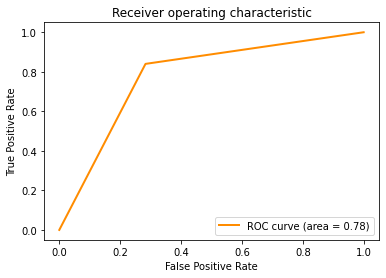

In [ ]:
# call test function    
test(loaders, model, criterion, use_cuda)